In [143]:
import pandas as pd
import numpy as np
from collections import deque
import json
import requests
import matplotlib.pyplot as plt

In [144]:
from useful_functions import crypto_raw_to_pandas, parse_all_book_updates, binary_price
from OrderBook import OrderBook

### Pulling In crypto data

In [145]:
crypto_data_filename = "btc_and_price_data/chainlink_crypto_prices_2025-10-30.jsonl"
df = crypto_raw_to_pandas(crypto_data_filename)

In [146]:
df.head()

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.081,crypto_prices_chainlink,update,3902042700000000000000,eth/usd,1761782690000,3902.042700
1,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.089,crypto_prices_chainlink,update,109992585115583980000000,btc/usd,1761782690000,109992.585116
2,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.084,crypto_prices_chainlink,update,2545512701164238700,xrp/usd,1761782690000,2.545513
3,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.086,crypto_prices_chainlink,update,193526622095049330000,sol/usd,1761782690000,193.526622
4,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.639,crypto_prices_chainlink,update,109994709366500000000000,btc/usd,1761782691000,109994.709366


In [147]:
btc_df = df[df['symbol'] == "btc/usd"].sort_values(by="unix_timestamp").reset_index(drop=True)

In [148]:
btc_df.head()

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value
0,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.089,crypto_prices_chainlink,update,109992585115583980000000,btc/usd,1761782690000,109992.585116
1,TO_BKeC3LPECFBw=,2025-10-30 00:04:51.639,crypto_prices_chainlink,update,109994709366500000000000,btc/usd,1761782691000,109994.709366
2,TO_BKeC3LPECFBw=,2025-10-30 00:04:52.922,crypto_prices_chainlink,update,109994244301159970000000,btc/usd,1761782692000,109994.244301
3,TO_BKeC3LPECFBw=,2025-10-30 00:04:54.049,crypto_prices_chainlink,update,109995046216000000000000,btc/usd,1761782693000,109995.046216
4,TO_BKeC3LPECFBw=,2025-10-30 00:04:54.635,crypto_prices_chainlink,update,109995246274500000000000,btc/usd,1761782694000,109995.246274


### IMPORTANT NOTE ABOUT STRIKE PRICE, IT IS ALWAYS THE PRICE THAT ARRIVES > 0.685s after the cutoff period

- 10/30 at 3:45 PM ET -> 63167	TRkfRcdTLPECEjw=	2025-10-30 19:45:01.084	106712029701995930000000	btc/usd	1761853500000	106712.029702
    -   True price = $106,712.03
    -   NOTE -> there was a price sent after time but it wasn't the price: 2025-10-30 19:45:00.354  106706018356014190000000	btc/usd	1761853499000	106706.018356
- 10/30 at 3:30 PM ET -> 62271	TRkfRcdTLPECEjw=	2025-10-30 19:30:00.800	update	106977710624929315000000	btc/usd	1761852600000	106977.710625
    -   True price = $106,977.71
- 10/30 at 3:15 PM ET -> 61390	TRkfRcdTLPECEjw=	2025-10-30 19:15:01.367	106875697703027500000000	btc/usd	1761851700000	106875.697703
    -   True price = $106,875.70
- 10/30 at 3:00 PM ET -> 60512	TRkfRcdTLPECEjw=	2025-10-30 19:00:00.899	106820959922286540000000	btc/usd	1761850800000	106820.959922
    -   True price = $106,820.96
- 10/30 at 2:45 PM ET -> 
    -   True price = $106,973.11


In [149]:
import datetime as dt
def get_strike_init_data(data):
    first_ts = data.iloc[0]['timestamp']
    last_ts = data.iloc[-1]['timestamp']
    current_ts = dt.datetime(first_ts.year, first_ts.month, first_ts.day, first_ts.hour, first_ts.minute//15*15, 0, 0)
    
    possible_strike_rows = []
    buffer = 2
    while current_ts < last_ts:
        possible_strike_rows.append(data[(data['timestamp'] >= current_ts) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=3, milliseconds=0)))])
        # if current_ts == dt.datetime(2025, 10, 30, 9, 30, 0, 0):
        #     print(data[(data['timestamp'] >= current_ts-dt.timedelta(seconds=1)) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=2, milliseconds=0)))])
        current_ts += dt.timedelta(minutes=15)
    
    return pd.concat(possible_strike_rows)


In [150]:
strikes = get_strike_init_data(btc_df)

In [151]:
data = btc_df
current_ts = dt.datetime(2025, 10, 30, 9, 30, 0, 0)

In [152]:
data[(data['timestamp'] >= current_ts) & (data['timestamp'] <= (current_ts+dt.timedelta(seconds=2, milliseconds=500)))]

,connection_id,timestamp,topic,type,full_accuracy_value,symbol,unix_timestamp,value


In [153]:
# for _, row in data.iterrows():
#     print(row)

In [154]:
for _, row in strikes.iterrows():
    print(row['timestamp'], row['unix_timestamp'], row['value'])

2025-10-30 00:15:00.386000 1761783299000 110162.8639665
2025-10-30 00:15:00.989000 1761783300000 110160.9871644047
2025-10-30 00:15:01.840000 1761783301000 110160.9871644047
2025-10-30 00:30:00.103000 1761784199000 110388.3482514329
2025-10-30 00:30:00.939000 1761784200000 110390.9333796622
2025-10-30 00:30:01.792000 1761784201000 110394.7311950606
2025-10-30 00:30:02.887000 1761784202000 110376.1688711866
2025-10-30 00:45:00.980000 1761785100000 110451.8235371067
2025-10-30 00:45:02.185000 1761785101000 110451.1106598826
2025-10-30 00:45:02.777000 1761785102000 110450.8876404633
2025-10-30 01:00:01.075000 1761786000000 110561.0117390768
2025-10-30 01:00:01.710000 1761786001000 110561.0358695384
2025-10-30 01:00:02.995000 1761786002000 110563.0515483759
2025-10-30 01:15:01.257000 1761786900000 110512.0406820323
2025-10-30 01:15:01.929000 1761786901000 110510.9228377613
2025-10-30 01:30:00.034000 1761787799000 110387.2652291621
2025-10-30 01:30:00.688000 1761787800000 110387.4496469187


In [155]:
ts = btc_df.iloc[0]['timestamp']
rounded_ts = dt.datetime(ts.year, ts.month, ts.day, ts.hour, ts.minute//15*15, 0, 0)

In [156]:
ts, rounded_ts

(Timestamp('2025-10-30 00:04:51.089000'),
 datetime.datetime(2025, 10, 30, 0, 0))

### Pulling Market Book Update Data

In [157]:
# Get market details from slug
url = "https://gamma-api.polymarket.com/events"
slug = "btc-updown-15m-1761786000"
response = requests.get(url, params={"slug": slug})

# yes_token_id, no_token_id = response.json()[0]['markets'][0]['clobTokenIds']
yes_token_id, no_token_id = json.loads(response.json()[0]['markets'][0]['clobTokenIds'])

In [158]:
yes_token_id

'83183308674131023197302415258788997759161749822734524473545155235350145282641'

In [159]:
messages = []

with open (f"btc_and_price_data/{slug}.jsonl") as f:
    # Thu Oct 30 2025 01:00:00 GMT+0000
    for line in f:
        line_data = json.loads(line)
        messages.append(line_data)

order_book_updates = parse_all_book_updates(messages)

In [160]:
trade_prices = [message for message in messages if type(message) == dict and message['event_type']=='last_trade_price']

In [161]:
len(trade_prices)

594

In [162]:
trade_prices[0]

{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
 'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',
 'price': '0.66',
 'size': '6',
 'fee_rate_bps': '0',
 'side': 'BUY',
 'timestamp': '1761786035832',
 'event_type': 'last_trade_price',
 'transaction_hash': '0x631e4f729d980e943ad1e5192fd99bebd9bd041a84180d0f78f9d2fe993553d6'}

In [163]:
def parse_last_trade_price(trade_event):
    # condition_id = trade_event['market']
    update = {
                "asset_id": trade_event['asset_id'],
                "timestamp": trade_event['timestamp'],
                "price": trade_event['price'],
                "size": trade_event['size'],
                "side": "bid" if trade_event['side'] == "BUY" else "ask",
                "fee_rate_bps": trade_event['fee_rate_bps']
            }

    return update

In [164]:
parse_last_trade_price(trade_event=trade_prices[0])

{'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',
 'timestamp': '1761786035832',
 'price': '0.66',
 'size': '6',
 'side': 'bid',
 'fee_rate_bps': '0'}

In [165]:
len(trade_prices)

594

In [166]:
trade_prices

[{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
  'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',
  'price': '0.66',
  'size': '6',
  'fee_rate_bps': '0',
  'side': 'BUY',
  'timestamp': '1761786035832',
  'event_type': 'last_trade_price',
  'transaction_hash': '0x631e4f729d980e943ad1e5192fd99bebd9bd041a84180d0f78f9d2fe993553d6'},
 {'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
  'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',
  'price': '0.66',
  'size': '6',
  'fee_rate_bps': '0',
  'side': 'BUY',
  'timestamp': '1761786036044',
  'event_type': 'last_trade_price',
  'transaction_hash': '0xfa07feb1f46f06bda524ca3c4fe3d92c9de7e5c5d4a059b87bdf932a6d97993d'},
 {'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
  'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',

In [167]:
# update to appropriate typings
for update in order_book_updates:
    update['price'] = float(update['price'])
    update['size'] = float(update['size'])
    update['timestamp'] = int(update['timestamp'])

In [168]:
yes_book_updates = [update for update in order_book_updates if update['asset_id'] == yes_token_id]
no_book_updates = [update for update in order_book_updates if update['asset_id'] == no_token_id]

In [169]:
found_error = False
for message in messages:
    if isinstance(message, dict) and message['timestamp'] == '1761786625422':
        print(message)
        found_error = True
    
    if found_error and message['event_type'] == 'book':
        print("BOOK")
        print(message)
        break

{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06', 'price_changes': [{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'price': '0.57', 'size': '9', 'side': 'BUY', 'hash': '0681075ad64ef940ac82645294e8e0a735cd9d6a', 'best_bid': '0.57', 'best_ask': '0.57'}, {'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682', 'price': '0.43', 'size': '9', 'side': 'SELL', 'hash': '7422b001053c4c98c44df8e767871f14eae76c09', 'best_bid': '0.43', 'best_ask': '0.43'}], 'timestamp': '1761786625422', 'event_type': 'price_change'}
BOOK
{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06', 'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'bids': [{'price': '0.01', 'size': '588'}, {'price': '0.02', 'size': '232'}, {'price': '0.03', 'size': '264'}, {'price': '0.04', 'size': '126'}, {'price': '0.05', 'size': '81'}, {'price': '0.06', 

In [170]:
1761786625422 - 1761786625423

-1

In [171]:
len(yes_book_updates), len(no_book_updates), len(yes_book_updates) + len(no_book_updates), len(order_book_updates)

(70462, 70460, 140922, 140922)

In [172]:
from collections import defaultdict
yes_update_by_timestamp = defaultdict(list)
no_update_by_timestamp = defaultdict(list)

for up in yes_book_updates:
    yes_update_by_timestamp[up['timestamp']].append(up)

for up in no_book_updates:
    no_update_by_timestamp[up['timestamp']].append(up)

#### TODO little search to find the 2 different entries

### Taking Vol and Order Book Data to price model and backtest

In [173]:
# yes_book_updates == sorted(yes_book_updates, key=lambda x: (x['timestamp'], x['price'])) # our yes book updates list is already in order
yes_book_updates = sorted(yes_book_updates, key=lambda x: (x['timestamp'], x['price']))

In [174]:
from collections import defaultdict
timestamp_counts = defaultdict(int)
for update in yes_book_updates:
    timestamp_counts[update['timestamp']] += 1

In [175]:
# timestamp = unique_ts[0]
# for i in range(5000):
#     if timestamp_counts[timestamp+i] > 10:
#         print(i, True)
#         break
# [timestamp_counts[timestamp + i] for i in range(100)]

In [176]:
# for timestamp in unique_ts:
#     for i in range(10000):
#         if timestamp_counts[timestamp+i] > 10:
#             # print(i)
#             break
#     print(i)

In [216]:
crypto_price_queue = deque(zip(btc_df['unix_timestamp'], btc_df['value']))
market_update_queue = deque(yes_book_updates)

In [178]:
yes_book_updates[67]

{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
 'timestamp': 1761786033795,
 'price': 0.2,
 'size': 11.0,
 'side': 'bid'}

In [217]:
unix_start_time = 1761786000 * 1000
unix_end_time = unix_start_time + 900*1000 #+ 20 * 1000 # buffer

In [218]:
class Vol:
    def __init__(self, effective_memory):
        self.effective_memory = effective_memory
        self.var_lambda = 1-1/effective_memory
        self.secs_in_year = 3.154e+7
        self.vol = 0
        self.prev_price = np.nan
    
    def compute_vol(self, return_val):
        return return_val**2

    def update_vol_from_price(self, price):
        if np.isnan(self.prev_price) or price <= 0:
            return_val = 0.0
        else:
            return_val = np.log(price/self.prev_price)
        vol_measurement = self.compute_vol(return_val) * self.secs_in_year # make it annualized assuming secondly data TODO -> this may be bad if delta t isn't 1 second
        self.vol = np.sqrt((1-self.var_lambda) * vol_measurement + self.var_lambda * (self.vol)**2)
        self.prev_price = price


In [256]:
from useful_functions import compute_vol
btc_df['returns'] = np.log(btc_df['value']).diff().dropna()
btc_df['vol'] = compute_vol(btc_df['returns'], effective_memory=6000)

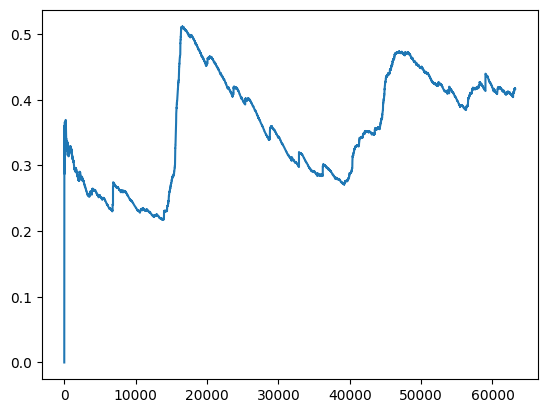

In [257]:
plt.plot(btc_df['vol'])

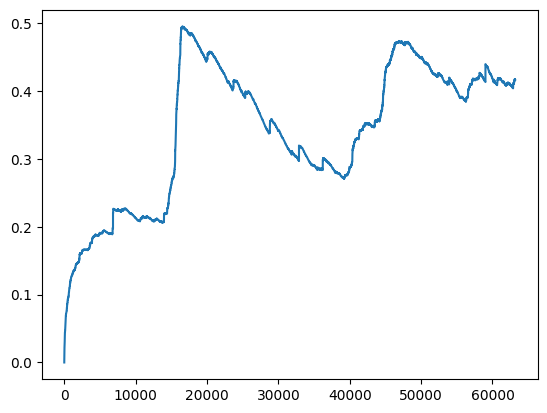

In [255]:
vol_tracker = Vol(effective_memory=6000)
prev_price = 100_000
vol_hist = []
for price in btc_df['value']:
    # return_val = np.log(price/prev_price)
    vol_tracker.update_vol_from_price(price)
    vol_hist.append(vol_tracker.vol)
    # prev_price = price

plt.plot(vol_hist)

NameError: name 'trade_yes_perspective' is not defined

In [222]:
## BACKTESTING

time = unix_start_time - 1800*1000 # # minus 5 minutes for crypto vol warm up, +1 time = +1 milliseconds
# point_685_seconds = 685 # 685 ms

data_over_time = []
crossed_timestamps = []

crypto_price = np.nan
vol = np.nan
market_price = np.nan
strike_price = np.nan
order_book = OrderBook()
vol_tracker = Vol(effective_memory=6000) # 5 minutes of effective memory? 1 hour?
resolve_price = np.nan


while time <= unix_end_time:
    if (time % 60000) == 0:
        print(time) # print every 60 seconds

    while crypto_price_queue and crypto_price_queue[0][0] <= time:
        crypto_timestamp, new_crypto_price = crypto_price_queue.popleft()
        vol_tracker.update_vol_from_price(new_crypto_price)

        if np.isnan(strike_price) and time == unix_start_time:
            # get the strike price of the market
            strike_price = new_crypto_price
        
        if np.isnan(resolve_price) and time == unix_end_time:
            resolve_price = new_crypto_price
    
        crypto_price = new_crypto_price

    tte = float((unix_end_time - time) / 3.154e+10) # milliseconds * (year / milliseconds)
    
    # now that we have a new price, get the option value
    theo_price = binary_price(S=crypto_price, X = strike_price, T=tte, vol = vol_tracker.vol, r = 0.0431) # r = sofr

    book_updates = []
    while market_update_queue and market_update_queue[0]['timestamp'] <= time:
        book_updates.append(market_update_queue.popleft())
    
    if len(book_updates) > 10:
        # if it's an order book
        order_book.bids.clear()
        order_book.asks.clear()
    if (order_book.batch_update(book_updates)):
        crossed_timestamps.append(order_book.updated_at)
        # update = market_update_queue.popleft()
        # if (order_book.update(side=update['side'], price=update['price'], size=update['size'], timestamp = update['timestamp'])):
        #     # undo the order and record it
        #     order_book.update(side=update['side'], price=update['price'], size=0, timestamp = update['timestamp'])
        #     print(update['timestamp'], update['side'], update['price'], update['size'], "Top:", order_book.best_bid, order_book.best_ask)

    # compute metrics and store
    data_point = {
        "timestamp": time,
        "crypto_price": crypto_price,
        "vol": vol_tracker.vol,
        "market_spread": order_book.spread,
        "best_bid": order_book.best_bid,
        "best_ask": order_book.best_ask,
        "theo_price": theo_price,
        "mid_price": order_book.mid,
        "lwm_price": order_book.lwm
    }
    data_over_time.append(data_point)
    time += 1

# figure out what the crypto final value was
# next_start_time = unix_start_time + 900*1000 # add 900 seconds

# while crypto_price_queue and np.isnan(resolve_price):
#     crypto_timestamp, new_crypto_price = crypto_price_queue.popleft()

#     if crypto_timestamp >= next_start_time + point_685_seconds:
#         # get the strike price of the market
#         resolve_price = new_crypto_price

# determine the final results of the market (later)

1761780000000
1761780060000
1761780120000
1761780180000
1761780240000
1761780300000
1761780360000
1761780420000
1761780480000
1761780540000
1761780600000
1761780660000
1761780720000
1761780780000
1761780840000
1761780900000
1761780960000
1761781020000
1761781080000
1761781140000
1761781200000
1761781260000
1761781320000
1761781380000
1761781440000
1761781500000
1761781560000
1761781620000
1761781680000
1761781740000
1761781800000
1761781860000
1761781920000
1761781980000
1761782040000
1761782100000
1761782160000
1761782220000
1761782280000
1761782340000
1761782400000
1761782460000
1761782520000
1761782580000
1761782640000
1761782700000
1761782760000
1761782820000
1761782880000
1761782940000
1761783000000
1761783060000
1761783120000
1761783180000
1761783240000
1761783300000
1761783360000
1761783420000
1761783480000
1761783540000
1761783600000
1761783660000
1761783720000
1761783780000
1761783840000
1761783900000
1761783960000
1761784020000
1761784080000
1761784140000
1761784200000
176178

/Users/willneuner/Desktop/FINTECH535/crypto-pred-mrkt-arb/useful_functions.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(S/X) - (r - (vol**2)/2) * T) / (vol * np.sqrt(T))


In [223]:
uniques = set()
unique_ts = []
for ts in crossed_timestamps:
    if ts not in uniques:
        unique_ts.append(ts)
        uniques.add(ts)

In [224]:
for update in yes_book_updates:
    if update['timestamp'] in uniques:
        print(update)

{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786625422, 'price': 0.57, 'size': 9.0, 'side': 'bid'}


In [225]:
order_book.pretty_print()

----- ORDER BOOK -----
|  PRICE  |  SIZE  |
|  0.99  |  432.0  |
|  0.98  |  219.0  |
|  0.97  |  198.0  |
|  0.96  |  75.0  |
|  0.95  |  30.0  |
|  0.94  |  20.0  |
|  0.93  |  20.0  |
|  0.92  |  10.0  |
|  0.91  |  10.0  |
|  0.9  |  10.0  |
|  0.66  |  20.0  |
|  0.64  |  20.0  |
|  0.63  |  20.0  |
|  0.62  |  20.0  |
|  0.6  |  20.0  |
|  0.59  |  20.0  |
|  0.58  |  20.0  |
|  0.54  |  20.0  |
|  0.53  |  20.0  |
|  0.48  |  20.0  |
|  0.47  |  20.0  |
|  0.46  |  20.0  |
|  0.45  |  20.0  |
|  0.43  |  20.0  |
|  0.42  |  20.0  |
|  0.41  |  20.0  |
|  0.4  |  20.0  |
|  0.39  |  20.0  |
|  0.38  |  20.0  |
|  0.13  |  5.0  |
|  0.09  |  5.0  |
|  0.08  |  73.99  |
|  0.07  |  11.0  |
|  0.06  |  4.25  |
--------------------
|  0.01  |  369.42  |


In [226]:
yes_book_updates[131]

{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
 'timestamp': 1761786035765,
 'price': 0.33,
 'size': 56.38,
 'side': 'bid'}

#### SOME OF THE ISSUES ARE THE FULL BOOK UPDATES

In [227]:
timestamp = 1761786036013 # 1761786035806
for i, update in enumerate(yes_book_updates):
    if update['timestamp'] == timestamp:
        print(i, update)
    
    # if update['timestamp'] > timestamp and update['timestamp'] < (timestamp+2):
    #     print(i, update)
    

208 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.01, 'size': 77897.0, 'side': 'bid'}
209 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.02, 'size': 2846.0, 'side': 'bid'}
210 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.03, 'size': 3527.0, 'side': 'bid'}
211 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.04, 'size': 9275.0, 'side': 'bid'}
212 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.05, 'size': 1176.0, 'side': 'bid'}
213 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641', 'timestamp': 1761786036013, 'price': 0.06

In [228]:
yes_book_updates[67:70]

[{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033795,
  'price': 0.2,
  'size': 11.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033800,
  'price': 0.34,
  'size': 415.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033855,
  'price': 0.37,
  'size': 39.0,
  'side': 'ask'}]

## Testing the books to see how the erroneous (cross) updates are handled

In [229]:
yes_book = []
for i, message in enumerate(messages):
    if isinstance(message, list):
        for market in message:
            if market['event_type'] != 'book':
                continue
            if market['asset_id'] == yes_token_id:
                yes_book.append((i, market))
    else:
        if message['event_type'] != 'book':
            continue
        
        if message['asset_id'] == yes_token_id:
                yes_book.append((i, message))



In [230]:
yes_book

[(0,
  {'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
   'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
   'timestamp': '1761786033748',
   'hash': 'f100e57251449abbd4750296f587b1891ccea79e',
   'bids': [{'price': '0.01', 'size': '77897'},
    {'price': '0.02', 'size': '2846'},
    {'price': '0.03', 'size': '3527'},
    {'price': '0.04', 'size': '9275'},
    {'price': '0.05', 'size': '1176'},
    {'price': '0.06', 'size': '173'},
    {'price': '0.07', 'size': '155'},
    {'price': '0.08', 'size': '127'},
    {'price': '0.09', 'size': '118'},
    {'price': '0.1', 'size': '306'},
    {'price': '0.11', 'size': '90'},
    {'price': '0.12', 'size': '113'},
    {'price': '0.13', 'size': '72'},
    {'price': '0.14', 'size': '72'},
    {'price': '0.15', 'size': '63'},
    {'price': '0.16', 'size': '7'},
    {'price': '0.17', 'size': '20'},
    {'price': '0.19', 'size': '16'},
    {'price': '0.2', 'size': '5'},
    

In [231]:
# messages[1][]

In [232]:
yes_book[0][0], yes_book[1][0] # 1761786033795 -> first cross is at this timestamp in between these
in_betweens = [(change, message['timestamp']) for message in messages[1:70] for change in message['price_changes'] if change['asset_id'] == '83183308674131023197302415258788997759161749822734524473545155235350145282641']

In [233]:
yes_book[0][1]['timestamp'], yes_book[1][1]['timestamp']

('1761786033748', '1761786035806')

In [234]:
yes_book[0][1]

{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
 'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
 'timestamp': '1761786033748',
 'hash': 'f100e57251449abbd4750296f587b1891ccea79e',
 'bids': [{'price': '0.01', 'size': '77897'},
  {'price': '0.02', 'size': '2846'},
  {'price': '0.03', 'size': '3527'},
  {'price': '0.04', 'size': '9275'},
  {'price': '0.05', 'size': '1176'},
  {'price': '0.06', 'size': '173'},
  {'price': '0.07', 'size': '155'},
  {'price': '0.08', 'size': '127'},
  {'price': '0.09', 'size': '118'},
  {'price': '0.1', 'size': '306'},
  {'price': '0.11', 'size': '90'},
  {'price': '0.12', 'size': '113'},
  {'price': '0.13', 'size': '72'},
  {'price': '0.14', 'size': '72'},
  {'price': '0.15', 'size': '63'},
  {'price': '0.16', 'size': '7'},
  {'price': '0.17', 'size': '20'},
  {'price': '0.19', 'size': '16'},
  {'price': '0.2', 'size': '5'},
  {'price': '0.23', 'size': '6'},
  {'price': '0.27', '

In [235]:
for change, timestamp in in_betweens:
    print(change['side'], change['price'], change['size'], timestamp)

SELL 0.38 30 1761786033766
BUY 0.23 0 1761786033768
SELL 0.37 159 1761786033769
BUY 0.2 11 1761786033795
BUY 0.34 415 1761786033800
SELL 0.37 39 1761786033855
BUY 0.34 410 1761786033859
SELL 0.37 20 1761786033872
SELL 0.42 51 1761786033878
BUY 0.32 30 1761786033880
BUY 0.33 16.38 1761786033945
BUY 0.3 0 1761786034148
SELL 0.37 50 1761786034179
BUY 0.31 35 1761786034182
BUY 0.32 20 1761786034183
SELL 0.37 40 1761786034184
SELL 0.37 30 1761786034185
SELL 0.37 60 1761786034186
SELL 0.37 90 1761786034189
SELL 0.37 120 1761786034192
SELL 0.37 130 1761786034227
BUY 0.32 30 1761786034230
SELL 0.38 40 1761786034232
BUY 0.32 40 1761786034235
SELL 0.37 10 1761786034295
SELL 0.37 20 1761786034316
SELL 0.38 58 1761786034328
SELL 0.38 40 1761786034364
BUY 0.26 51 1761786034467
SELL 0.4 51 1761786034470
SELL 0.4 451 1761786034552
SELL 0.37 10 1761786034712
SELL 0.37 0 1761786034889
BUY 0.32 30 1761786034892
SELL 0.38 58 1761786034900
BUY 0.2 5 1761786034917
BUY 0.32 20 1761786034919
SELL 0.38 48 176

In [236]:
yes_book[1][1]

{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
 'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
 'bids': [{'price': '0.01', 'size': '77897'},
  {'price': '0.02', 'size': '2846'},
  {'price': '0.03', 'size': '3527'},
  {'price': '0.04', 'size': '9275'},
  {'price': '0.05', 'size': '1176'},
  {'price': '0.06', 'size': '173'},
  {'price': '0.07', 'size': '155'},
  {'price': '0.08', 'size': '127'},
  {'price': '0.09', 'size': '118'},
  {'price': '0.1', 'size': '306'},
  {'price': '0.11', 'size': '90'},
  {'price': '0.12', 'size': '113'},
  {'price': '0.13', 'size': '72'},
  {'price': '0.14', 'size': '72'},
  {'price': '0.15', 'size': '63'},
  {'price': '0.16', 'size': '7'},
  {'price': '0.17', 'size': '20'},
  {'price': '0.19', 'size': '16'},
  {'price': '0.2', 'size': '5'},
  {'price': '0.26', 'size': '51'},
  {'price': '0.27', 'size': '51'},
  {'price': '0.28', 'size': '51'},
  {'price': '0.29', 'size': '51'},

In [237]:
in_betweens

[({'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
   'price': '0.38',
   'size': '30',
   'side': 'SELL',
   'hash': '22b9b5a3622e86d06336143307f8f10c6d0f4615',
   'best_bid': '0.34',
   'best_ask': '0.37'},
  '1761786033766'),
 ({'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
   'price': '0.23',
   'size': '0',
   'side': 'BUY',
   'hash': '4ae91920c36822f390822dd2d28155d9c8fc5d71',
   'best_bid': '0.34',
   'best_ask': '0.37'},
  '1761786033768'),
 ({'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
   'price': '0.37',
   'size': '159',
   'side': 'SELL',
   'hash': 'f3f9033e798ca9f9bd5d93b1ecc546a86bde0bd9',
   'best_bid': '0.34',
   'best_ask': '0.37'},
  '1761786033769'),
 ({'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
   'price': '0.2',
   'size': '11',
   'side': 'BUY',
   'hash': '114ce8320ad62d06f

In [238]:
len(trade_prices)

594

In [239]:
len(yes_book)

597

In [240]:
yes_book_updates[:]

[{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.01,
  'size': 77897.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.02,
  'size': 2846.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.03,
  'size': 3527.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.04,
  'size': 9275.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.05,
  'size': 1176.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp':

In [241]:
trade_prices[0]

{'market': '0x9444d31814238a9d89fed3eab0e2782da96eb9b7bf1ba5da8663edeee137ec06',
 'asset_id': '41962797971457692471944227875529019000673384934005887575219956926514413062682',
 'price': '0.66',
 'size': '6',
 'fee_rate_bps': '0',
 'side': 'BUY',
 'timestamp': '1761786035832',
 'event_type': 'last_trade_price',
 'transaction_hash': '0x631e4f729d980e943ad1e5192fd99bebd9bd041a84180d0f78f9d2fe993553d6'}

In [242]:
order_book.pretty_print()

----- ORDER BOOK -----
|  PRICE  |  SIZE  |
|  0.99  |  432.0  |
|  0.98  |  219.0  |
|  0.97  |  198.0  |
|  0.96  |  75.0  |
|  0.95  |  30.0  |
|  0.94  |  20.0  |
|  0.93  |  20.0  |
|  0.92  |  10.0  |
|  0.91  |  10.0  |
|  0.9  |  10.0  |
|  0.66  |  20.0  |
|  0.64  |  20.0  |
|  0.63  |  20.0  |
|  0.62  |  20.0  |
|  0.6  |  20.0  |
|  0.59  |  20.0  |
|  0.58  |  20.0  |
|  0.54  |  20.0  |
|  0.53  |  20.0  |
|  0.48  |  20.0  |
|  0.47  |  20.0  |
|  0.46  |  20.0  |
|  0.45  |  20.0  |
|  0.43  |  20.0  |
|  0.42  |  20.0  |
|  0.41  |  20.0  |
|  0.4  |  20.0  |
|  0.39  |  20.0  |
|  0.38  |  20.0  |
|  0.13  |  5.0  |
|  0.09  |  5.0  |
|  0.08  |  73.99  |
|  0.07  |  11.0  |
|  0.06  |  4.25  |
--------------------
|  0.01  |  369.42  |


In [243]:
strike_price

110561.0117390768

In [244]:
resolve_price

110512.0406820323

In [245]:
backtest_df = pd.DataFrame(data_over_time)

In [246]:
len(backtest_df)

6900001

In [247]:
backtest_df.dropna()

,timestamp,crypto_price,vol,market_spread,best_bid,best_ask,theo_price,mid_price,lwm_price
6033748,1761786033748,110502.900752,0.166853,0.03,0.34,0.37,0.273535,0.355,0.342903
6033749,1761786033749,110502.900752,0.166853,0.03,0.34,0.37,0.273535,0.355,0.342903
6033750,1761786033750,110502.900752,0.166853,0.03,0.34,0.37,0.273535,0.355,0.342903
6033751,1761786033751,110502.900752,0.166853,0.03,0.34,0.37,0.273535,0.355,0.342903
6033752,1761786033752,110502.900752,0.166853,0.03,0.34,0.37,0.273535,0.355,0.342903
...,...,...,...,...,...,...,...,...,...
6899996,1761786899996,110516.011648,0.185478,0.05,0.01,0.06,0.000000,0.035,0.059431
6899997,1761786899997,110516.011648,0.185478,0.05,0.01,0.06,0.000000,0.035,0.059431
6899998,1761786899998,110516.011648,0.185478,0.05,0.01,0.06,0.000000,0.035,0.059431
6899999,1761786899999,110516.011648,0.185478,0.05,0.01,0.06,0.000000,0.035,0.059431


### Analysis of the backtest

In [248]:
import matplotlib.pyplot as plt

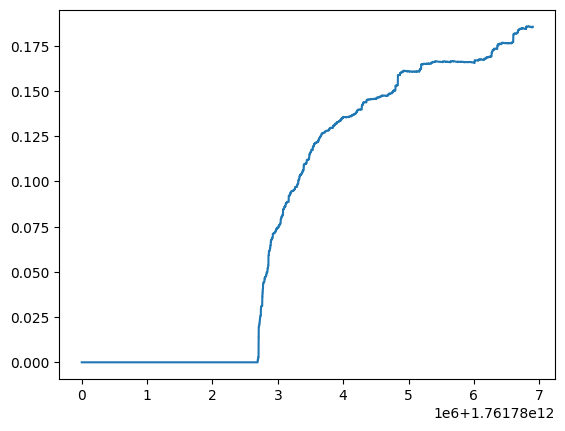

In [249]:
plt.plot(backtest_df['timestamp'], backtest_df['vol'])

In [250]:
yes_book_updates

[{'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.01,
  'size': 77897.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.02,
  'size': 2846.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.03,
  'size': 3527.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.04,
  'size': 9275.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp': 1761786033748,
  'price': 0.05,
  'size': 1176.0,
  'side': 'bid'},
 {'asset_id': '83183308674131023197302415258788997759161749822734524473545155235350145282641',
  'timestamp':

In [251]:
backtest_df.iloc[-1]

timestamp        1.761787e+12
crypto_price     1.105120e+05
vol              1.854807e-01
market_spread    5.000000e-02
best_bid         1.000000e-02
best_ask         6.000000e-02
theo_price       0.000000e+00
mid_price        3.500000e-02
lwm_price        5.943132e-02
Name: 6900000, dtype: float64

In [252]:
order_book.pretty_print()

----- ORDER BOOK -----
|  PRICE  |  SIZE  |
|  0.99  |  432.0  |
|  0.98  |  219.0  |
|  0.97  |  198.0  |
|  0.96  |  75.0  |
|  0.95  |  30.0  |
|  0.94  |  20.0  |
|  0.93  |  20.0  |
|  0.92  |  10.0  |
|  0.91  |  10.0  |
|  0.9  |  10.0  |
|  0.66  |  20.0  |
|  0.64  |  20.0  |
|  0.63  |  20.0  |
|  0.62  |  20.0  |
|  0.6  |  20.0  |
|  0.59  |  20.0  |
|  0.58  |  20.0  |
|  0.54  |  20.0  |
|  0.53  |  20.0  |
|  0.48  |  20.0  |
|  0.47  |  20.0  |
|  0.46  |  20.0  |
|  0.45  |  20.0  |
|  0.43  |  20.0  |
|  0.42  |  20.0  |
|  0.41  |  20.0  |
|  0.4  |  20.0  |
|  0.39  |  20.0  |
|  0.38  |  20.0  |
|  0.13  |  5.0  |
|  0.09  |  5.0  |
|  0.08  |  73.99  |
|  0.07  |  11.0  |
|  0.06  |  4.25  |
--------------------
|  0.01  |  369.42  |


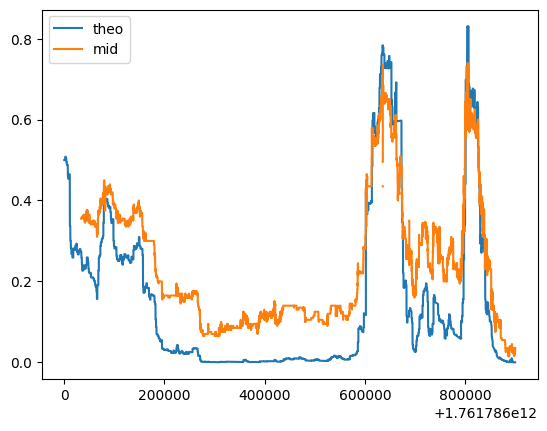

In [253]:
backtest_df = backtest_df[(backtest_df['timestamp']>=unix_start_time) & (backtest_df['timestamp']<=unix_end_time)]
plt.plot(backtest_df['timestamp'], backtest_df['theo_price'], label="theo")
plt.plot(backtest_df['timestamp'], backtest_df['mid_price'], label="mid")
# plt.plot(backtest_df['timestamp'], backtest_df['lwm_price'], label="lwm")
# plt.plot(backtest_df['timestamp'], backtest_df['market_spread'], label="spread")
plt.legend()